In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras
import keras.backend as K
import tensorflow as tf
import random
import os
import time
import glob

from keras.callbacks import Callback

from ssd_model import SSD300, SSD512
from ssd_utils import PriorUtil
from ssd_utils import load_weights
from ssd_data import InputGenerator
from ssd_data import preprocess
from ssd_training import SSDLoss, SSDFocalLoss, LearningRateDecay, Logger

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

### Data

#### Pascal VOC

In [3]:
from data_voc import GTUtility
gt_util = GTUtility('data/VOC2007/')
gt_util_train, gt_util_val = gt_util.split(gt_util, split=0.8)
experiment_name = 'ssd512_voc'
#print(gt_util)

#### MS COCO

In [ ]:
from data_coco import GTUtility
gt_util = GTUtility('data/COCO/')
gt_util_train, gt_util_val = gt_util.split(gt_util, split=0.8)
experiment_name = 'ssd512_coco'
#print(gt_util)

### Model

In [4]:
#model = SSD300(num_classes=gt_util.num_classes)
model = SSD512(num_classes=gt_util.num_classes)

### Example data

In [5]:
#gt_util = gt_util_train
gt_util = gt_util_val
np.random.seed(1337)
idxs = np.random.randint(0, gt_util.num_samples, 8)
img_h, img_w = image_size = model.image_size

data = []
inputs = []
images = []
for i in idxs:
    img_path = os.path.join(gt_util.image_path, gt_util.image_names[i])
    img = cv2.imread(img_path)
    inputs.append(preprocess(img, image_size))
    img = cv2.resize(img, (img_w, img_h), cv2.INTER_LINEAR)
    img = img[:, :, (2,1,0)] # BGR to RGB
    img = img / 256.
    images.append(img)
    data.append(gt_util.data[i])
inputs = np.asarray(inputs)

# plot ground truth
#for i in range(len(images)):
#    plt.figure()
#    plt.imshow(images[i])
#    gt_util.plot_gt(data[i])
#    plt.show()

### Priors

In [6]:
prior_util = PriorUtil(model)

# plot prior boxes
#for m in prior_util.prior_maps:
#    plt.figure()
#    plt.imshow(images[0])
#    m.plot_locations()
#    m.plot_boxes([0, 10, 100])
#    plt.show()

### Weights

In [7]:
initial_epoch = 0

weights_path = '~/.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
layer_list = [('block1_conv1', 'conv1_1'),
              ('block1_conv2', 'conv1_2'),
              ('block2_conv1', 'conv2_1'),
              ('block2_conv2', 'conv2_2'),
              ('block3_conv1', 'conv3_1'),
              ('block3_conv2', 'conv3_2'),
              ('block3_conv3', 'conv3_3'),
              ('block4_conv1', 'conv4_1'),
              ('block4_conv2', 'conv4_2'),
              ('block4_conv3', 'conv4_3'),
              ('block5_conv1', 'conv5_1'),
              ('block5_conv2', 'conv5_2'),
              ('block5_conv3', 'conv5_3')]
#load_weights(model, weights_path, layer_list)

#model.load_weights('ssd512_voc_weights_fixed.hdf5', by_name=True)
#model.load_weights('./checkpoints/201709191502_ssd_voc/weights.051.h5', by_name=True); initial_epoch = 52
#model.load_weights('./checkpoints/201709251316_ssd512_coco/weights.040.h5', by_name=True); initial_epoch = 41
model.load_weights('./checkpoints/201709081909_ssd512_voc/weights.034.h5', by_name=True); initial_epoch = 35

freeze = ['conv1_1', 'conv1_2',
          'conv2_1', 'conv2_2',
          'conv3_1', 'conv3_2', 'conv3_3',
          #'conv4_1', 'conv4_2', 'conv4_3',
          #'conv5_1', 'conv5_2', 'conv5_3',
         ]

### Training

In [ ]:
epochs = 100
batch_size = 24

gen = InputGenerator(gt_util_train, gt_util_val, prior_util, 
        batch_size, model.image_size, vflip_prob=0.0, do_crop=False)

# freeze layers
for l in model.layers:
    l.trainable = not l.name in freeze

checkdir = './checkpoints/' + time.strftime('%Y%m%d%H%M') + '_' + experiment_name
if not os.path.exists(checkdir):
    os.makedirs(checkdir)

with open(checkdir+'/source.py','wb') as f:
    source = ''.join(['# In[%i]\n%s\n\n' % (i, In[i]) for i in range(len(In))])
    f.write(source.encode())

#optim = keras.optimizers.SGD(lr=1e-3, momentum=0.9, decay=0, nesterov=True)
optim = keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

# weight decay
regularizer = keras.regularizers.l2(5e-4) # None if disabled
for l in model.layers:
    if l.__class__.__name__.startswith('Conv'):
        l.kernel_regularizer = regularizer

loss = SSDLoss(alpha=1.0, neg_pos_ratio=3.0)
#loss = SSDFocalLoss()

model.compile(optimizer=optim,
              loss=loss.compute,
              metrics=loss.metrics)
        
callbacks = [keras.callbacks.ModelCheckpoint(checkdir+'/weights.{epoch:03d}.h5',
                                             verbose=1, save_weights_only=True),
             Logger(checkdir),
             #LearningRateDecay(methode='linear', base_lr=1e-3, n_desired=40000, desired=0.1, bias=0.0, minimum=0.1)
            ]

history = model.fit_generator(gen.generate(train=True, augmentation=True), #generator, 
                              gen.num_train_batches*3, #steps_per_epoch, # TODO
                              epochs=epochs, 
                              verbose=1, 
                              callbacks=callbacks, 
                              validation_data=gen.generate(train=False, augmentation=True), 
                              validation_steps=gen.num_val_batches, 
                              class_weight=None, 
                              #max_queue_size=10, 
                              workers=1, 
                              #use_multiprocessing=False, 
                              initial_epoch=initial_epoch)

### Prediction

In [8]:
preds = model.predict(inputs, batch_size=1, verbose=1)

8/8 [==============================] - 1s 115ms/step


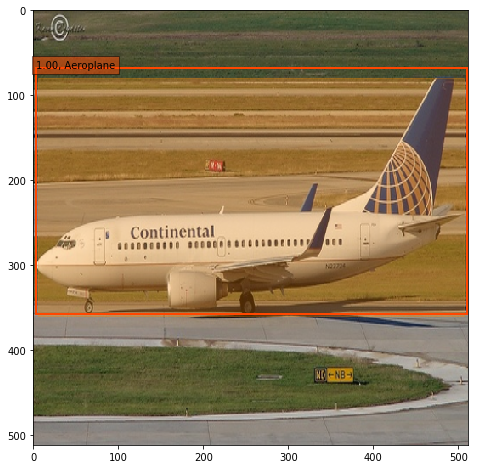

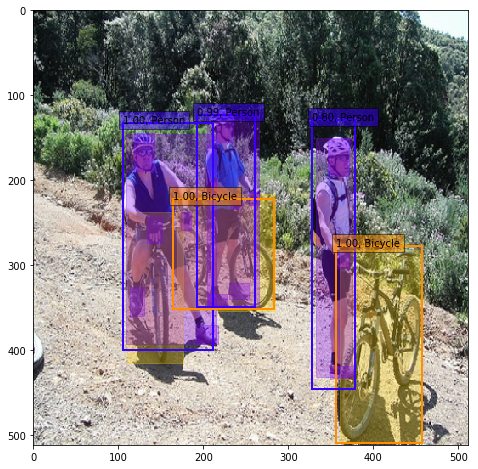

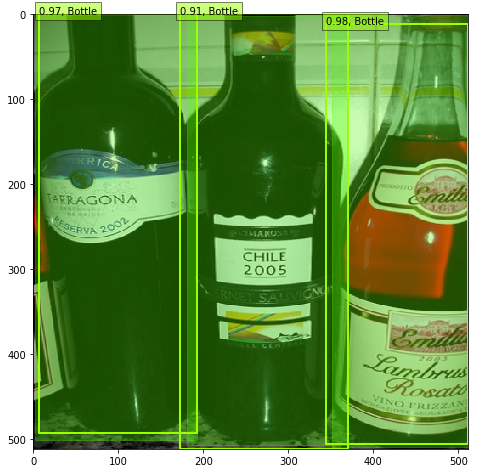

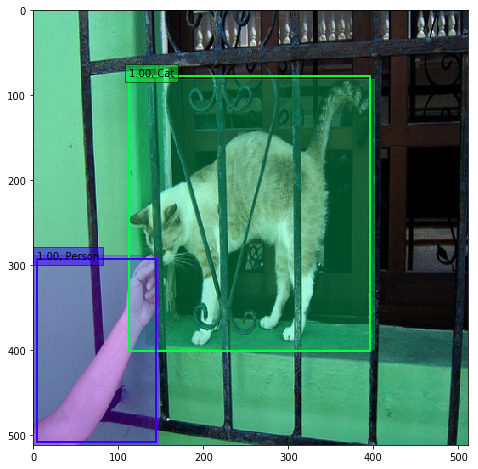

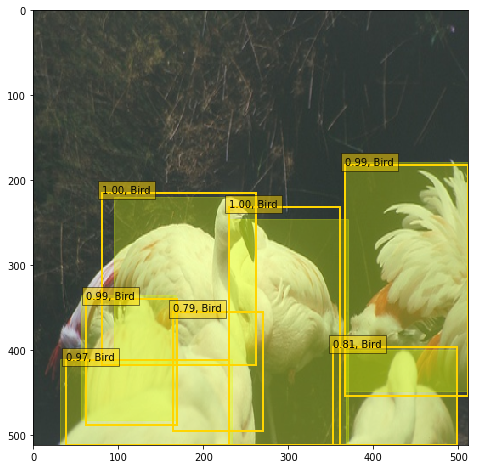

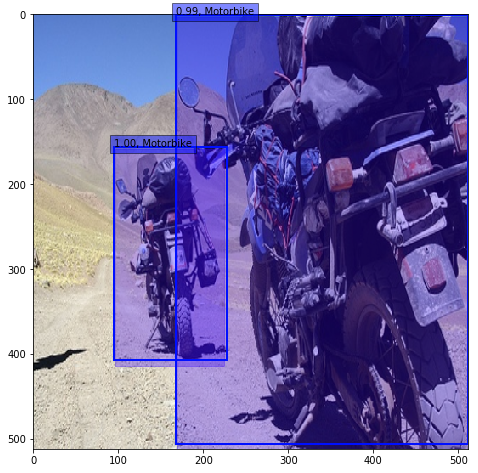

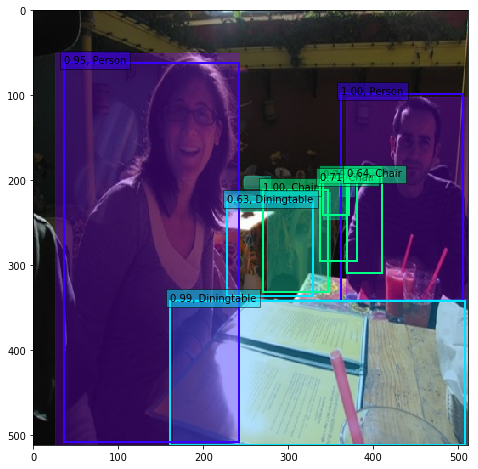

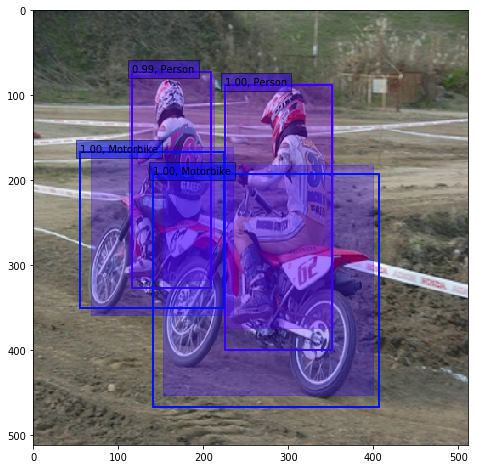

In [9]:
experiment = '201709191502_ssd_voc'

for fl in glob.glob('checkpoints/%s/result_*' % (experiment,)):
    os.remove(fl)

for i in range(len(preds)):
    plt.figure()
    plt.imshow(images[i])
    res = prior_util.decode(preds[i], confidence_threshold=0.6)
    prior_util.plot_results(res, classes=gt_util.classes, show_labels=True, gt_data=data[i])
    #prior_util.plot_results(res, classes=gt_util.classes, show_labels=True, gt_data=None)
    #plt.savefig('checkpoints/%s/result_%03d.jpg' % (experiment, i))
    plt.show()

In [ ]:
import pickle

results = []
for i in range(len(preds)):
    res = prior_util.decode(preds[i], confidence_threshold=0.6)
    results.append(res)

test_eval_data = {
    'gt': data,
    'inputs': inputs,
    'images': images,
    'results': results
}

pickle.dump(test_eval_data, open('test_eval_data.pkl','wb'))